Lagrangian Tracer Bloom Model
==

Based on v00, not clear exactly what has changed aside from pointing to bloom_tracers_v01
rather than bloom_tracers_v09.

Later updated to point to newer bloom_tracers_v10 run.

2024-09-26: copied from plot_dfm_bloom_tracers_v04refactor, trying to streamline notebook, move some
code into separate py file

In [487]:
import matplotlib.pyplot as plt
%matplotlib widget

Support / Prep
--

In [488]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils, memoize, xr_utils, xr_transect
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.plot import plot_utils, plot_wkb, mkanim

from stompy.grid import unstructured_grid
from matplotlib import colors, cm
import matplotlib.colorbar as cbar
import pandas as pd
import os
import numpy as np
import xarray as xr
import subprocess
from scipy.integrate import solve_ivp

import stompy.plot.cmap as scmap

from numba import njit
from stompy.spatial import field
from scipy import ndimage

from IPython.display import Video

import time
import six
import datetime
import glob
from stompy.plot import nbviz

In [489]:
# These online-coupled dfm-dwaq runs.
import bloom_common
#six.moves.reload_module(bloom_common)
from bloom_common import load_model, ratio, chl_from_RS
import tracer_group
six.moves.reload_module(tracer_group)
from tracer_group import TracerGroup, tracer_groups


In [490]:
grid_poly = tracer_groups[0].grid.boundary_polygon()
turbo_low = scmap.cmap_transform(cm.turbo,lambda i: i**0.75)

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249223, 15 potential interiors


Linearized Light Limitation
--

In [491]:
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912 and t.initial=='alameda'][0]

ds=tg.model.map_dataset()

Text(0.02, 0.03, '2022-08-21 03:20 PDT')

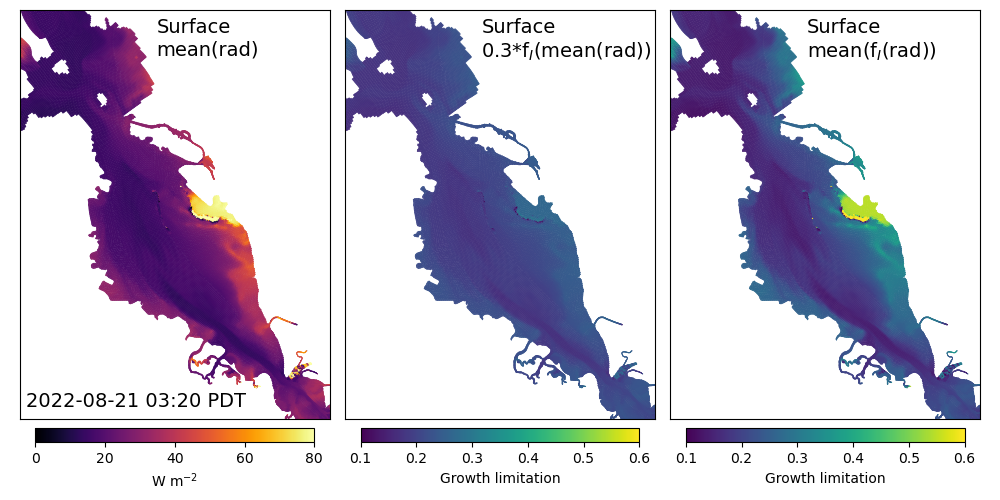

In [492]:
tidx=400

# First, the basic light limitation calculation:
layer="Surface"
sel=dict(time=tidx,laydim=15)
conc=tg['conc'].isel(**sel).values
radc=tg['radc'].isel(**sel).values
kradA=tg['kRadA'].isel(**sel).values
kradB=tg['kRadB'].isel(**sel).values

# DFM gets some negative concentrations. Slightly better to take abs of everything.
# For lagrangian model doesn't matter too much since concentration is quite low.
conc=np.abs(conc)
radc=np.abs(radc)
kradA=np.abs(kradA)
kradB=np.abs(kradB)

age=((tg.ds.time[tidx] - tg.ds.time[0])/np.timedelta64(24,'h')).item()
rad=ratio(radc, age*conc)
radA=ratio(kradA,age*conc)
radB=ratio(kradB,age*conc)
zoom=(544806.72535673, 584499.458477138, 4145536.190742454, 4197985.175969432)

Isat=10.0
fRad = radA

#Isat=20.0
#fRad = radB

panels=[
    #dict(scal=conc,clim=[1e-4,10],label='conc', cmap='turbo', norm=colors.LogNorm),
    dict(scal=rad,clim=[0,80],label='mean(rad)', cmap='inferno', units='W m$^{-2}$'),
    dict(scal=0.3*rad/(rad+Isat),clim=[0.1,0.6],label='0.3*f$_I$(mean(rad))',cmap='viridis', units='Growth limitation'),
    dict(scal=fRad,clim=[0.1,0.6],label='mean(f$_I$(rad))',cmap='viridis', units='Growth limitation')
]

fig,axs=plt.subplots(1,len(panels),figsize=(10,5))
fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,wspace=0.05)
for ax,panel in zip(axs,panels):
    ax.set_adjustable('datalim')
    ccoll=tg.grid.plot_cells(values=panel['scal'],cmap=panel.get('cmap','turbo'),
                             norm=panel.get('norm',colors.Normalize)(),
                             lw=0.5,ec='face',clim=panel['clim'],ax=ax)
    plt.colorbar(ccoll,orientation='horizontal',label=panel.get('units',''),shrink=0.9,fraction=0.1,pad=0.02)
    ax.text(0.44,0.98,f"{layer}\n{panel['label']}",
            fontsize=14,transform=ax.transAxes,va='top')

    ax.axis(zoom)
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)

axs[0].text(0.02,0.03,utils.strftime(ds.time[400].values - np.timedelta64(7,'h'),
                                     "%Y-%m-%d %H:%M PDT"),
            fontsize=14,transform=axs[0].transAxes)

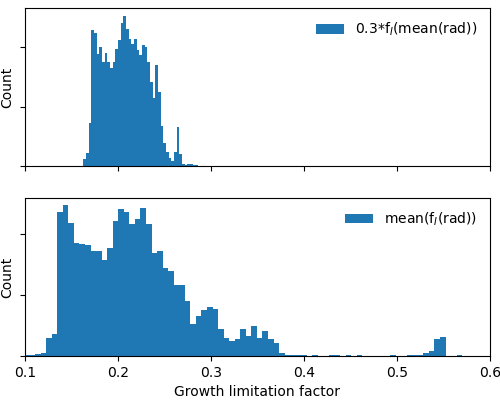

In [493]:
# Histogram, too
fig,axs=plt.subplots(2,1,sharex=True,figsize=(5,4))
cell_sel = tg.grid.cell_clip_mask(zoom)
for ax,panel in zip(axs,panels[1:]):
    scal=panel['scal'][cell_sel]
    scal=scal[ np.isfinite(scal) & (scal>0) & (scal<0.6) ]
    ax.hist(scal,label=panel['label'],bins=100)
    ax.legend(loc='upper right',frameon=0)

    plt.setp(ax.get_yticklabels(),visible=0)
    ax.set_ylabel('Count')
ax.set_xlabel('Growth limitation factor')
ax.axis(xmin=0.1,xmax=0.6)
fig.subplots_adjust(left=0.05,right=0.98,top=0.98)

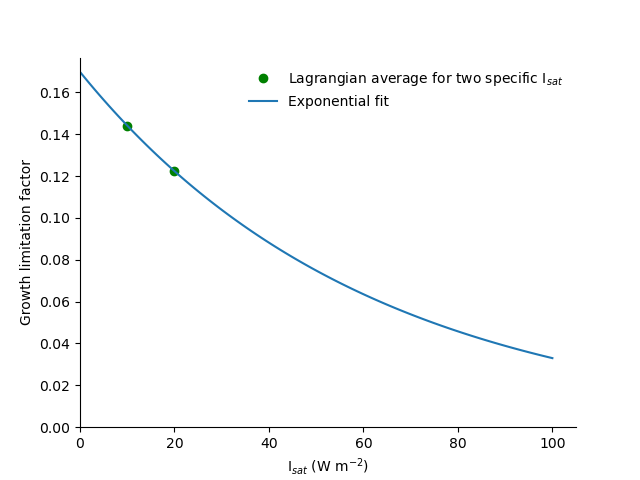

In [494]:
# Interpolation of fLim data points
# Say we 
pnt=[566200,4.1595e6]
cell=tg.grid.select_cells_nearest(pnt)

IsatA=10.0
IsatB=20.0
fA=radA[cell]
fB=radB[cell]

Isat=np.linspace(0,100,100)

# Linear interpolation
fIsat_lin = fA + (Isat-IsatA)/(IsatB-IsatA)*(fB-fA)

# But we know that as Isat goes to inf, should asymptote to 0.0,
# and as Isat goes to zero, should asymptote to 0.5 (as a nod to diurnal)
f0=0.17
kIsat=0.015
# fI_exp = f0*np.exp(-kI*I)
# log(fI_exp)  = -kI*I + log(f0)
kIsat,log_f0 = np.polyfit(np.r_[IsatA,IsatB],np.log(np.r_[fA,fB]),1)


f0=np.exp(log_f0)
fIsat_exp = f0*np.exp(kIsat*Isat)

fig,ax=plt.subplots()
ax.plot([IsatA,IsatB],[fA,fB],'go',label='Lagrangian average for two specific I$_{sat}$')
#ax.plot(Isat,fIsat_lin,'g-',label='Linear interpolation')
ax.plot(Isat,fIsat_exp,label='Exponential fit')

ax.set_xlabel('I$_{sat}$ (W m$^{-2}$)')
ax.set_ylabel('Growth limitation factor') 
ax.legend(loc='upper right',frameon=0)
ax.axis(ymin=0.0,xmin=0.0)
ax.spines['top'].set_visible(0)
ax.spines['right'].set_visible(0)

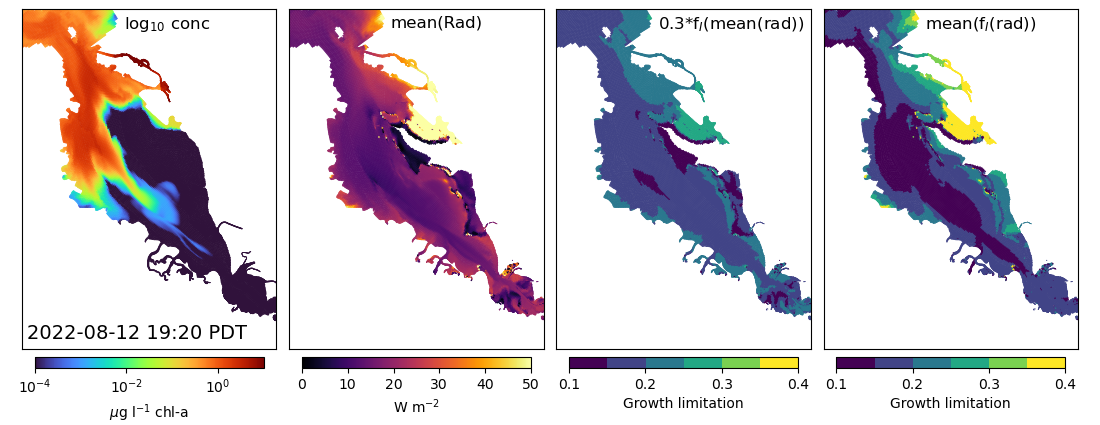

In [514]:
fig=tg.figure_fields(tidx=400,
                     fields=['logConc','meanRad','fMeanRad','meanFRadA'],
                     zoom=(550862., 582466., 4.14e6, 4.19e6)
                     )

Lagrangian Model
--

In [496]:
# Panel for P and a panel for N.
from solveNP import solveNP

In [497]:
# Lagrangian vs. RS chl

class FigLagrangianSnapshot:
    group=None
    tidx=None
    layer=15
    thresh=1e-2 
    c0=3
    kprod=1.0 
    N0=35 # initial DIN, uM
    Nsat=0.5 # half-sat DIN, uM
    kmort=0.05
    Isat=10.0
    background=0.0
    colorbar=True

    figsize=(11,4)
    fig=None
    zoom=(540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806)
    panels=['lagP','lagN','remoteP']
    cmap=turbo_low
    adjust=dict(left=0.01, right=0.97, top=0.98, bottom=0.02)
        
    N_clim=[0,40]
    chl_clim=[0,220]
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)

        t=self.group.ds.time.values[self.tidx]
        rs_chl = chl_from_RS(t,grid_poly)

        result = solveNP(group=self.group,
                         tidx=self.tidx,
                         layer=self.layer,
                         thresh=self.thresh,
                         c0=self.c0,
                         kprod=self.kprod,
                         N0=self.N0, # initial DIN, uM
                         Nsat=self.Nsat, # half-sat DIN, uM
                         kmort=self.kmort,
                         background=self.background,
                         P_nodata=self.background,
                         Isat=self.Isat)
        self.result=result

        if self.fig is None:
            fig,axs=plt.subplots(1,len(self.panels),figsize=self.figsize,squeeze=False)
            axs=axs[0,:]
            self.fig=fig
        else:
            fig=self.fig
            fig.clf()
            axs = np.array([fig.add_subplot(1,len(self.panels),i+1) for i in range(len(self.panels))])
        self.axs=axs
        fig.subplots_adjust(**self.adjust)
        if self.colorbar:
            caxs=[cbar.make_axes(ax)[0] for ax in axs]
        else:
            caxs=[None] * len(axs)
        
        self.caxs=caxs
        kw=dict(lw=0.5,edgecolor='face')
        cmap=self.cmap
    
        for ax in axs:
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)    
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
    
        for ax,cax,panel in zip(axs,caxs,self.panels):
            if panel=='lagP':
                ccoll=self.group.grid.plot_cells( values=result.P, ax=ax, cmap=cmap, **kw)
                ccoll.set_clim(self.chl_clim)
                if cax is not None:
                    plt.colorbar(ccoll,label=r'chl-a ($\mu$g l$^{-1}$)',ax=ax,cax=cax)
                    
                txt=self.model_text()
                ax.text(0.49,0.9, txt, va='top',transform=ax.transAxes)

                param_txt=self.param_text()
                if param_txt:
                    ax.text(0.06,0.02, param_txt, va='bottom',
                            transform=ax.transAxes)
            elif panel=='lagN':
                ccoll=self.group.grid.plot_cells( values=result.N, ax=ax, cmap=cmap, **kw)
                ccoll.set_clim(self.N_clim)
                if cax is not None:
                    plt.colorbar(ccoll,label=r'N (mg l$^{-1}$)',ax=ax,cax=cax)            
            elif panel=='remoteP':
                if rs_chl is not None: # RS scene
                    rs_chl.plot(ax=ax,cmap=cmap,clim=self.chl_clim)
                    if cax is not None:
                        cax.set_visible(0)
                    txt = self.rs_text(t)
                    if txt:
                        ax.text(0.49,0.9, txt, va='top',transform=ax.transAxes)
                else:
                    ax.text(0.5,0.5,"No RS data",transform=ax.transAxes, ha='center')
            
        for ax in axs:
            ax.axis(self.zoom)

    def swimming_text(self):
        tg=self.group
        if np.isreal(tg.swim):
            return f"{tg.swim} m/d"
        else:
            return f"{np.imag(tg.swim)} m/d diurnal"

    def param_text(self):
        param_txt=[]
        for fld in ['kprod','kmort','Isat','c0']:
            param_txt.append( f"{fld}={self.result[fld].values}" )
        return "\n".join(param_txt)
    
    def model_text(self):
        return "\n".join([utils.strftime(self.result.time-np.timedelta64(7,'h'))+" PDT",
                          self.swimming_text(),
                          f"Layer: {self.layer}",
                          f"Initial: {self.group.initial}"])
    def rs_text(self,t):
        return utils.strftime(t,"%Y-%m-%d")
        
        

In [498]:
# Banding in the output:
#  Present in the concentration field straight from DFM output
#  Not associated with domain partitions
#  Unclear if it's an artifact from turbulent mixing
#  Not present for passive scalar, only swimming

In [499]:
# optimize params for v13 / 6.912j
# base_params=dict(c0=1.17, kprod=1.87, N0=35, Nsat=5, kmort=0.07, Isat=5.6, background=8.8)
# After correcting RS data to 11:20 PDT
base_params=dict(c0=1.364,kprod=1.784,N0=35.000,Nsat=5.000,kmort=0.067,Isat=6.102,background=8.926)

In [500]:
# Slimmed down for ppt

class SlimFig(FigLagrangianSnapshot):
    adjust=dict(left=0.01, right=0.97, top=0.98, bottom=0.05, wspace=0.02)
    def model_text(self):
        return utils.strftime(self.result.time-np.timedelta64(7,'h'),"%Y-%m-%d\n%H:%M PDT")
    def param_text(self):
        return None

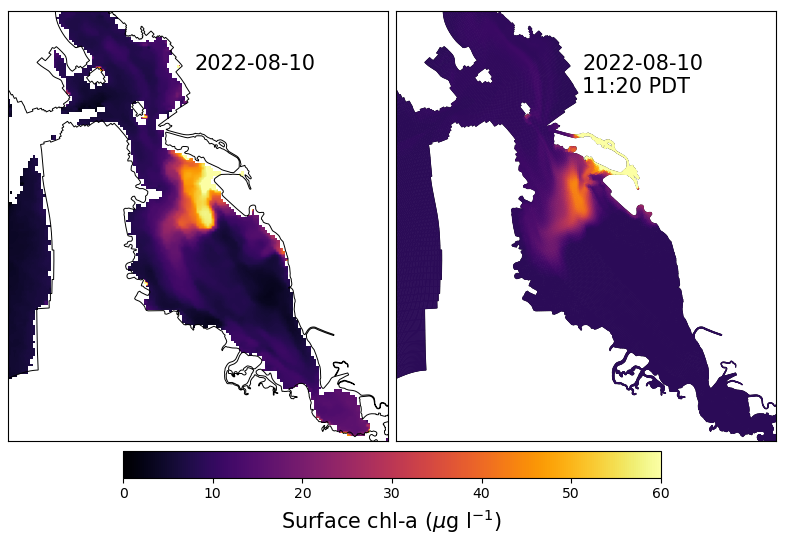

In [516]:
        
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912j and t.initial=='alameda'][0]
fig=SlimFig(group=tg,
            tidx=144,
            #tidx=500,
            layer=1,
            panels=['remoteP','lagP'],colorbar=False,
            figsize=(8,5.5),cmap='inferno',chl_clim=[0,60],
            **base_params)
              
fig.fig.subplots_adjust(wspace=0.02)
for ax in fig.fig.axes:
    plt.setp(ax.texts,fontsize=15)
coll=fig.axs[1].collections[0]
cbar=plt.colorbar(coll,ax=fig.axs, orientation='horizontal',fraction=0.14,pad=0.02,shrink=0.7)
cbar.set_label(r'Surface chl-a ($\mu$g l$^{-1}$)',fontsize=15)
# Nonlinear
if 0:
    coll.set_norm(colors.AsinhNorm(vmin=5,vmax=200))
    ticks=[5,10,20,50,100,200]
    cbar.ax.set_xticks(ticks)
    cbar.ax.set_xticklabels([str(t) for t in ticks])

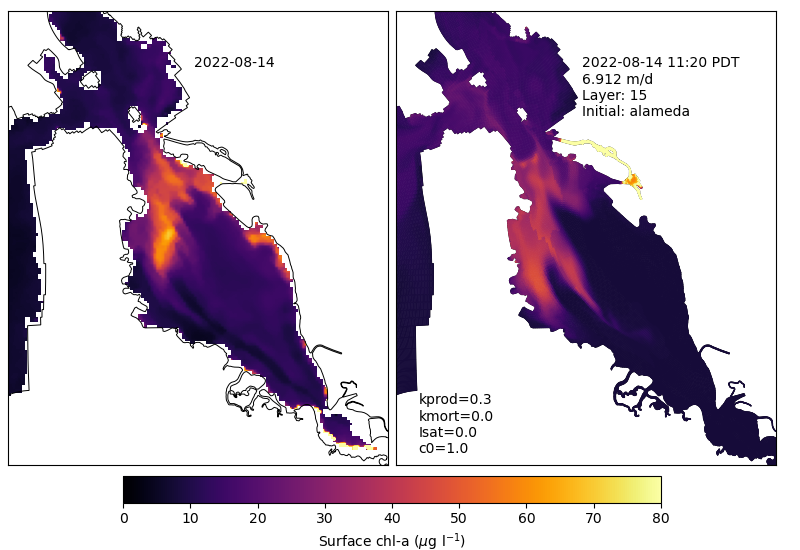

In [502]:
# No light limitation - at this swim speed simple vertical dilution and flushing
# in Central Bay keeps the bloom tamed.
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912 and t.initial=='alameda'][0]
fig=FigLagrangianSnapshot(group=tg,tidx=240,layer=15,
                          panels=['remoteP','lagP'],colorbar=False,
                          figsize=(8,5.5),cmap='inferno',chl_clim=[0,80],
                          kprod=0.3, c0=1.0, N0=35, Nsat=1.0, kmort=0.0, Isat= 0.0, background=8.0)
fig.fig.subplots_adjust(wspace=0.02)
coll=fig.axs[1].collections[0]
cax=plt.colorbar(coll,ax=fig.axs, orientation='horizontal',fraction=0.12,pad=0.02,shrink=0.7,
                label=r'Surface chl-a ($\mu$g l$^{-1}$)')

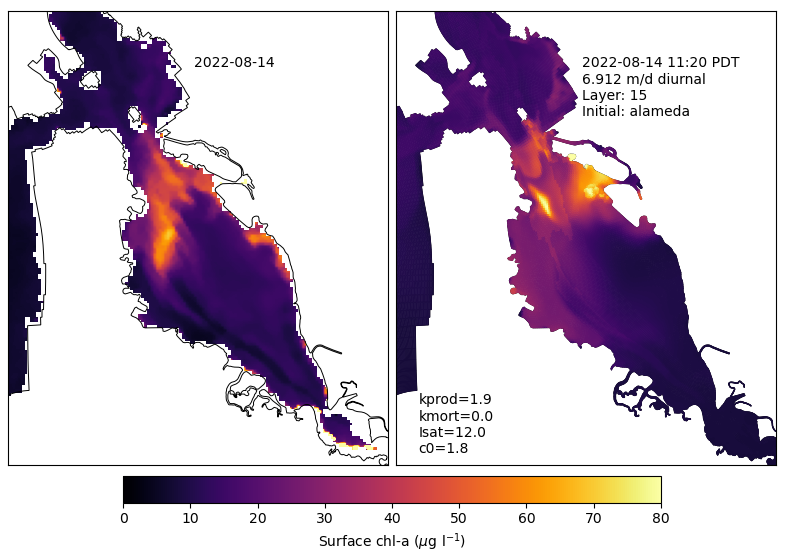

In [503]:
# Checking on diffusion run - better agreement against 10:20 PDT than against 12:20
tg = [t for t in tracer_groups if t.tag=='v15' and t.swim==6.912j and t.initial=='alameda'][0]
fig=FigLagrangianSnapshot(group=tg,tidx=240,layer=15,
                          panels=['remoteP','lagP'],colorbar=False,
                          figsize=(8,5.5),cmap='inferno',chl_clim=[0,80],
                          kprod=1.9, c0=1.8, N0=20, Nsat=5.0, kmort=0.0, Isat= 12.0, background=8.0)
fig.fig.subplots_adjust(wspace=0.02)
#plt.setp(fig.axs[1].texts,visible=0)
coll=fig.axs[1].collections[0]
cax=plt.colorbar(coll,ax=fig.axs, orientation='horizontal',fraction=0.12,pad=0.02,shrink=0.7,
                label=r'Surface chl-a ($\mu$g l$^{-1}$)')

In [504]:
#tidx=73 # 8/7 noon
#tidx=97 # 8/8
#tidx=121
#tidx=145 # 8/10
#tidx=169 # 8/11
#tidx=193 # 8/12
#tidx=217 # 8/13
#tidx=241 # 8/14 - starts to drift away from RS
#tidx=265 # 8/15
#tidx=289 # 8/16
#tidx=289+24 # 8/17 - no RS
#tidx=289+48 # 8/18
#tidx=385 # 8/20
#tidx=409 # 8/21
#tidx=433 # 8/22 12:20

# What does it take to get a bloom if I apply the 0.4 attenuation factor
# for light distribution, and a fixed 0.7 g_max?

#FigLagrangianSnapshot(group=tg,tidx=tidx,layer=15,kprod=1.4,c0=10,kmort=0.1,panels=['lagP','remoteP'],Isat=10.0)
if 0:
    tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912 and t.initial=='alameda'][0]
    FigLagrangianSnapshot(group=tg,tidx=217,layer=15,**base_params,panels=['lagP','remoteP'])

Sensitivity Figures
--

In [524]:
# Panels comparing effect of swimming speeds, Isat, temp/no-temp
from matplotlib import gridspec

class FigLagrangianDiff:
    group=None
    tidx=tidx=216+4*24
    layer=15
    thresh=1e-2 
    c0=base_params['c0']
    kprod=base_params['kprod'] 
    N0=35 # initial DIN, uM
    Nsat=base_params['Nsat'] # half-sat DIN, uM
    kmort=base_params['kmort']
    Isat=base_params['Isat']
    background=base_params['background']
    cases=None

    figsize=(10,5.2)
    zoom=(540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806)
    chl_cmap='inferno'
    chl_clim=[0,60]
    dchl_cmap='coolwarm'
    dchl_clim=[-10,10]
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        if self.group is None:
            self.group=self.cases[0]['group']

        t=self.group.ds.time.values[self.tidx]

        base=dict(group=self.group,
                  tidx=self.tidx,
                  layer=self.layer,
                  thresh=self.thresh,
                  c0=self.c0,
                  kprod=self.kprod,
                  N0=self.N0,
                  Nsat=self.Nsat,
                  kmort=self.kmort,
                  Isat=self.Isat)
        
        results=[]
        case_params=[]
        for case in self.cases:
            params = dict(base)
            params.update(case)
            case_params.append(params)
            result = solveNP(**params)
            results.append(result)

        self.results=results

        fig=plt.figure(figsize=self.figsize)
        self.fig=fig
        gs=gridspec.GridSpec(2,6,height_ratios=[0.93,0.07])
        self.axs=axs=[fig.add_subplot(gs[0,0:2]),
                      fig.add_subplot(gs[0,2:4]),
                      fig.add_subplot(gs[0,4:6])]
        self.caxs=caxs=[fig.add_subplot(gs[1,1:3]),
                        fig.add_subplot(gs[1,4:6])]
        
        for ax in axs:
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)    
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax,zorder=3)
        
        kw=dict(lw=0.5,edgecolor='face')
        for ax,result,case,params in zip(axs[:2],results,self.cases,case_params):
            ccoll=params['group'].grid.plot_cells( values=result.P, ax=ax, cmap=self.chl_cmap, **kw)
            ccoll.set_clim(self.chl_clim)
            label=case.get('label',None)
            if label:
                label = label+"\n"+self.time_str()
            else:
                label = self.time_str()
            ax.text(0.46,0.98,label,transform=ax.transAxes,fontsize=13,va='top')

        cbar=plt.colorbar(ccoll,cax=caxs[0],orientation='horizontal',
                         shrink=0.5)
        cbar.set_label(r'chl-a ($\mu$g l$^{-1}$)',fontsize=13)

        ax=axs[2]
        dcoll=case_params[0]['group'].grid.plot_cells(values=results[1].P - results[0].P, ax=ax, cmap=self.dchl_cmap,**kw)
        dcoll.set_clim(self.dchl_clim)
        cbar=plt.colorbar(dcoll,cax=caxs[1],orientation='horizontal')
        cbar.set_label(r'Change in chl-a ($\mu$g l$^{-1}$)',fontsize=13)

        for ax in axs:
            ax.axis(self.zoom)
            
        fig.subplots_adjust(top=0.98,left=0.02,right=0.98,bottom=0.15,wspace=0.05,hspace=0.05)
    def time_str(self):
        tg=self.group
        return utils.strftime(tg.ds.time.values[self.tidx] - np.timedelta64(7,'h'),"%m/%d %H:%M PDT")
        

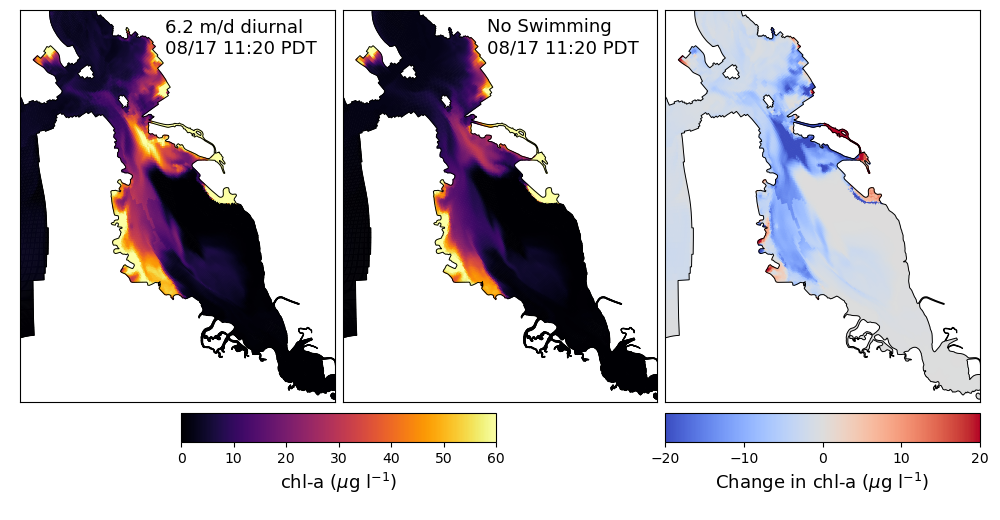

In [526]:
# Swimming vs no swimming
tg_6p9 = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912 and t.initial=='alameda'][0]
tg_0   = [t for t in tracer_groups if t.tag=='v13' and t.swim==0.0 and t.initial=='alameda'][0]

fig=FigLagrangianDiff(cases=[dict(label='6.2 m/d diurnal',group=tg_6p9),
                             dict(label='No Swimming',group=tg_0)],
                      layer=15, dchl_clim=[-20,20],
                      **base_params)


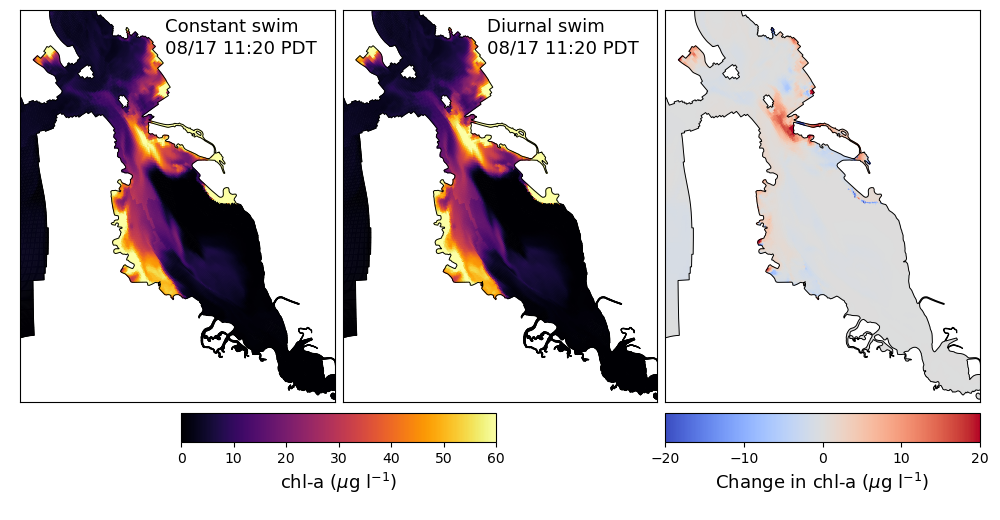

In [507]:
# Constant swimming vs diurnal swimming
tg_6p9    = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912  and t.initial=='alameda'][0]
tg_diurnal= [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912j and t.initial=='alameda'][0]

fig=FigLagrangianDiff(cases=[dict(label='Constant swim',group=tg_6p9),
                             dict(label='Diurnal swim',group=tg_diurnal)],
                      dchl_clim=[-20,20],
                     **base_params)

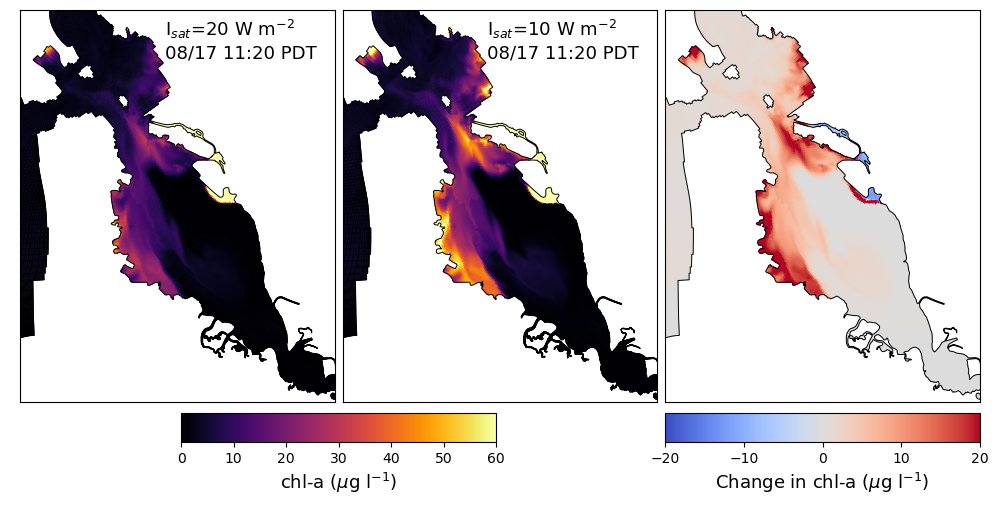

In [508]:
# Isat 20 vs 10
tg  = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912 and t.initial=='alameda'][0]

fig=FigLagrangianDiff(cases=[dict(label=r'I$_{sat}$=20 W m$^{-2}$',Isat=20.0),
                             dict(label=r'I$_{sat}$=10 W m$^{-2}$',Isat=10.0)],
                      group=tg, layer=15,dchl_clim=[-20,20],
                      **base_params)

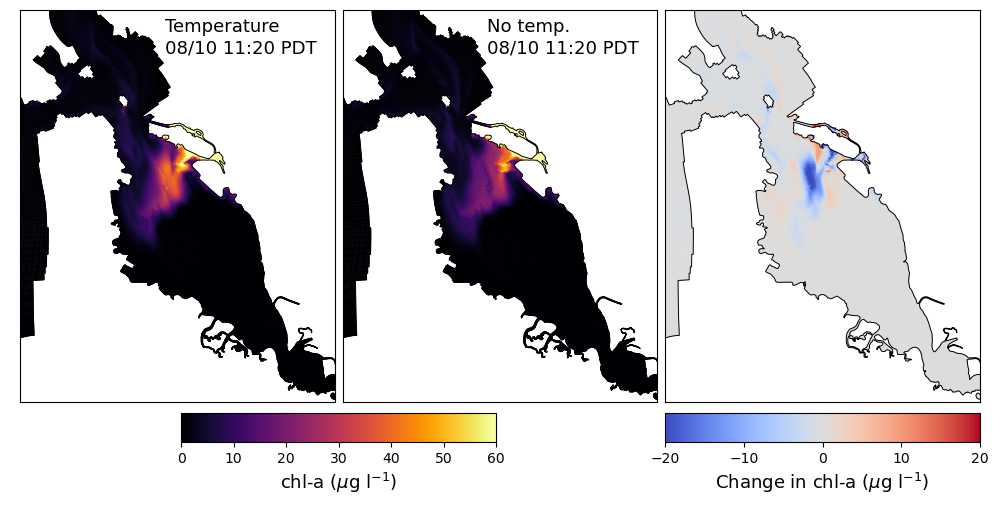

In [509]:
# Temperature (with swimming)
tg_temp    = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912 and t.initial=='alameda'][0]
tg_notemp  = [t for t in tracer_groups if t.tag=='v14' and t.swim==6.912 and t.initial=='alameda'][0]

fig=FigLagrangianDiff(cases=[dict(label='Temperature',group=tg_temp),
                             dict(label='No temp.',group=tg_notemp)],
                      #tidx=193,
                      tidx=144,
                      layer=15,dchl_clim=[-20,20],
                      **base_params)

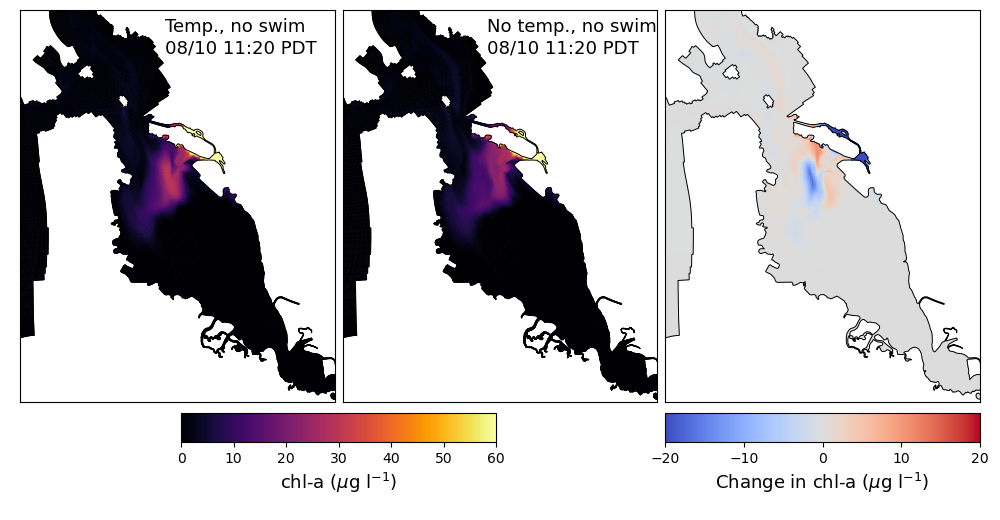

In [510]:
# Temperature (without swimming)
tg_temp    = [t for t in tracer_groups if t.tag=='v13' and t.swim==0.0 and t.initial=='alameda'][0]
tg_notemp  = [t for t in tracer_groups if t.tag=='v14' and t.swim==0.0 and t.initial=='alameda'][0]

fig=FigLagrangianDiff(cases=[dict(label='Temp., no swim',group=tg_temp),
                             dict(label='No temp., no swim',group=tg_notemp)],
                      tidx=144,layer=15,dchl_clim=[-20,20],
                      **base_params)

In [511]:
tg_diff.ds.reload()
tg_diff.ds.dims['time']

468

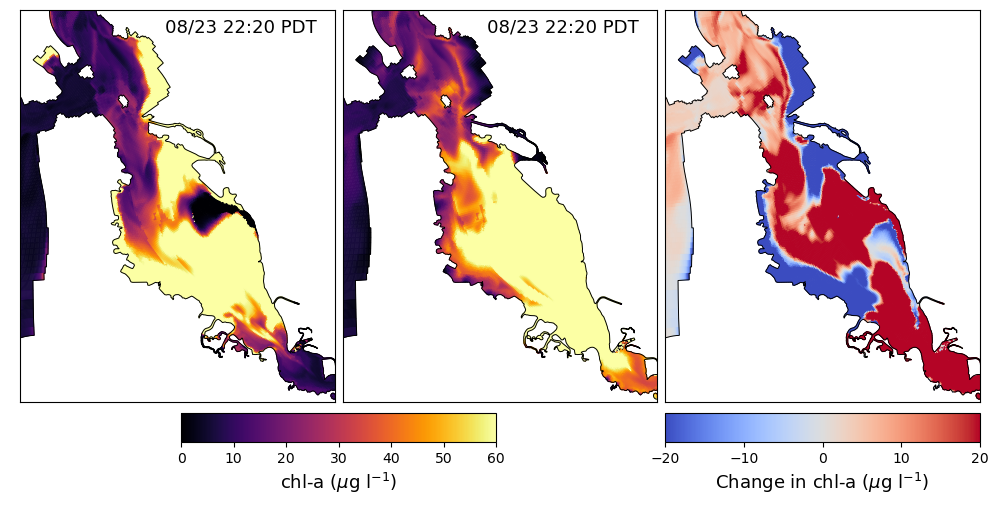

In [512]:
tg_orig   = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912 and t.initial=='alameda'][0]
tg_diff   = [t for t in tracer_groups if t.tag=='v15' and t.swim==6.912 and t.initial=='alameda'][0]

tg_diff.ds.reload()
tidx=tg_diff.ds.dims['time']-1
fig=FigLagrangianDiff(cases=[dict(group=tg_orig),dict(group=tg_diff)],
                      tidx=tidx,layer=15,dchl_clim=[-20,20],
                      **base_params)

In [513]:

class FigLagrangianIngredients:
    group=None
    tidx=tidx=216+4*24
    layer=15
    thresh=1e-2 
    c0=base_params['c0']
    kprod=base_params['kprod'] 
    N0=35 # initial DIN, uM
    Nsat=base_params['Nsat'] # half-sat DIN, uM
    kmort=base_params['kmort']
    Isat=base_params['Isat']
    background=base_params['background']

    figsize=(10,5.2)
    zoom=(540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806)
    chl_cmap='inferno'
    chl_clim=[0,60]
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        if self.group is None:
            self.group=self.cases[0]['group']

        t=self.group.ds.time.values[self.tidx]

        base=dict(group=self.group,
                  tidx=self.tidx,
                  layer=self.layer,
                  thresh=self.thresh,
                  c0=self.c0,
                  kprod=self.kprod,
                  N0=self.N0,
                  Nsat=self.Nsat,
                  kmort=self.kmort,
                  Isat=self.Isat)
        
        result = solveNP(**base)

        self.results=results

        fig=plt.figure(figsize=self.figsize)
        self.fig=fig
        gs=gridspec.GridSpec(2,6,height_ratios=[0.93,0.07])
        self.axs=axs=[fig.add_subplot(gs[0,0:2]),
                      fig.add_subplot(gs[0,2:4]),
                      fig.add_subplot(gs[0,4:6])]
        self.caxs=caxs=[fig.add_subplot(gs[1,1:3]),
                        fig.add_subplot(gs[1,4:6])]
        
        for ax in axs:
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)    
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax,zorder=3)
        
        kw=dict(lw=0.5,edgecolor='face')
        if 1: # Chl:
            ax = self.axs[0]
            ccoll=base['group'].grid.plot_cells( values=result.P, ax=ax, cmap=self.chl_cmap, **kw)
            ccoll.set_clim(self.chl_clim)
            label = self.time_str()
            ax.text(0.46,0.98,label,transform=ax.transAxes,fontsize=13,va='top')
    
            cbar=plt.colorbar(ccoll,cax=caxs[0],orientation='horizontal',
                             shrink=0.5)
            cbar.set_label(r'chl-a ($\mu$g l$^{-1}$)',fontsize=13)

        if 0: # log conc:
            ax=self.axs[1]
            coll=base['group'].grid.plot_cells(values=result.P, ax=ax, cmap=self.log_conc_cmap,
                                               norm=colors.LogNorm(), **kw)
            coll.set_clim(self.log_conc_clim)
            cbar=plt.colorbar(dcoll,cax=caxs[1],orientation='horizontal')
            cbar.set_label(r'Conc. ($\mu$g l$^{-1}$)',fontsize=13)

        for ax in axs:
            ax.axis(self.zoom)
            
        fig.subplots_adjust(top=0.98,left=0.02,right=0.98,bottom=0.15,wspace=0.05,hspace=0.05)
    def time_str(self):
        tg=self.group
        return utils.strftime(tg.ds.time.values[self.tidx] - np.timedelta64(7,'h'),"%m/%d %H:%M PDT")

Animation
--

Group: conc2_6.9mpd_diurnal_alameda  Output to bloom_tracers_v13/run_20220804T1820_20220830T0000_v01/frames_v02_conc2_6.9mpd_diurnal_alameda
   movie file: bloom_tracers_v13/run_20220804T1820_20220830T0000_v01/frames_v02_conc2_6.9mpd_diurnal_alameda/lagra_v02_conc2_6.9mpd_diurnal_alameda.mp4
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470

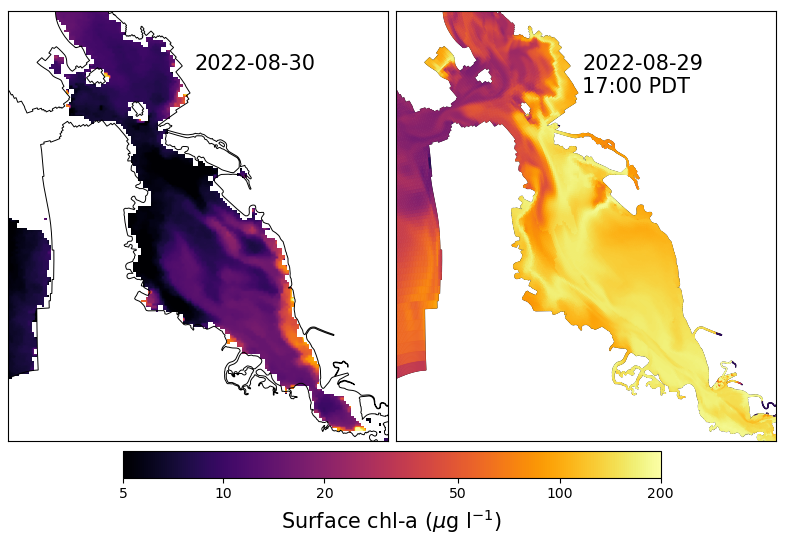

In [456]:
# Animation

tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912j and t.initial=='alameda'][0]
params=base_params

# Diffusion!
#tg = [t for t in tracer_groups if t.tag=='v15' and t.swim==6.912j and t.initial=='alameda'][0]
#params=dict(thresh=0.010,c0=1.948,kprod=1.416,N0=35.000,Nsat=2.078,kmort=0.038,Isat=10.604,background=8.207)

# v00: linear colors
# v01: asinh nonlinear colors
# v02: asinh nonlinear colors, fix bug where it was only applied to model
frame_dir=os.path.join(tg.run_dir,f"frames_v02_{tg.tracer_short_name}")
movie_fn=os.path.join(frame_dir,f"lagra_v02_{tg.tracer_short_name}.mp4")

print(f"Group: {tg.tracer_short_name}  Output to {frame_dir}")
print(f"   movie file: {movie_fn}")
updated=False
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)

fig=None
force=False
for tidx in range(tg.ds.dims['time']):
    img_fn=os.path.join(frame_dir,"frame_%04d.png"%tidx)
    if os.path.exists(img_fn) and not force:
        continue

    print(tidx)
    
    slim=SlimFig(group=tg,tidx=tidx,layer=15,fig=fig,
                 panels=['remoteP','lagP'],colorbar=False,
                 figsize=(8,5.5),cmap='inferno',chl_clim=[0,60],
                 **base_params)
    fig=slim.fig                          
    for ax in fig.axes:
        plt.setp(ax.texts,fontsize=15)           
    coll=fig.axes[1].collections[0]
    cbar=plt.colorbar(coll,ax=fig.axes, orientation='horizontal',fraction=0.14,pad=0.02,shrink=0.7)
    cbar.set_label(r'Surface chl-a ($\mu$g l$^{-1}$)',fontsize=15)
    if 1: # nonlinear cbar
        mappables=[ fig.axes[1].collections[0] ]
        if fig.axes[0].images:
            mappables.append(fig.axes[0].images[0])
        for mappable in mappables:
            mappable.set_norm(colors.AsinhNorm(vmin=5,vmax=200))
        ticks=[5,10,20,50,100,200]
        cbar.ax.set_xticks(ticks)
        cbar.ax.set_xticklabels([str(t) for t in ticks])
    fig.savefig(img_fn,dpi=100)
    updated=True


In [457]:
# Compile to animation
import subprocess
if os.path.exists(movie_fn):
    if updated:
        os.unlink(movie_fn)
if not os.path.exists(movie_fn):
    subprocess.run(f"ffmpeg -framerate 10 -i {os.path.join(frame_dir,'frame_%04d.png')} "
                    "-c:v libx264 -preset slow -profile:v high -level:v 4.0 "
                   f"-pix_fmt yuv420p -crf 20 -r 10 {movie_fn}",
                   shell=True)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [459]:
movie_fn

'bloom_tracers_v13/run_20220804T1820_20220830T0000_v01/frames_v02_conc2_6.9mpd_diurnal_alameda/lagra_v02_conc2_6.9mpd_diurnal_alameda.mp4'

In [458]:
Video(movie_fn) 

OLD Slice Plots
--

In [224]:
# line from W span of bay bridge to about Redwood City
from shapely import wkt
profile_geom_channel=wkt.loads("""
LineString (553934.46602910873480141 4185292.98902965523302555, 556003.0745520245982334 4182475.40155878709629178,
557144.37580604711547494 4180335.46170749515295029, 557964.68608237581793219 4178231.18752039084210992, 
558250.01139588153455406 4176198.24466166319325566, 558606.66803776356391609 4172631.67824284266680479,
559248.64999315119348466 4169279.10580915166065097, 560211.62292623275425285 4166283.19001734210178256,
561994.90613564301747829 4163750.92785997968167067, 563706.85801667685154825 4161896.31332219298928976,
565882.46353215735871345 4159970.36745603010058403, 568129.40037601429503411 4158650.73788106627762318,
571089.65050363529007882 4156831.78900746814906597, 573728.90965356235392392 4154406.52384267002344131)
""") 

# similar northern run, but in the middle of San Bruno Shoal head out across the shoal
profile_geom_shoal=wkt.loads("""
LineString (553943.43526522838510573 4185306.34642233327031136, 555905.91317636473104358 4182700.43313049618154764, 
557064.09686162555590272 4180319.72222190443426371, 557932.7346255712909624 4178099.8701584879308939, 
558318.79585399152711034 4175686.98748086113482714, 558447.48293013160582632 4174046.2272600750438869, 
558994.40300372685305774 4171392.05631468491628766, 560184.75845802284311503 4169477.83605710230767727,
562565.46936661447398365 4168030.10645052650943398, 570930.12931572052184492 4165456.3649277244694531,
574211.64975729293655604 4164716.4142399188131094)
""")

tidx=10
tg = [t for t in tracer_groups if t.tag=='v12' and t.swim==6.912j and t.initial=='uniform'][0]

profile_name="channel"
tran = tg.extract_transect(profile_geom_channel, 10)



In [226]:
class SliceAnimation:
    save=True
    tg=None # tracer group

    profile_name=None
    linestring=None
    normalize = True
    force = False
    render_mp4=True
    mp4_settings=[dict(name='_12fps',fps=12),
                  dict(name='_6fps',fps=6)]
    
    def __init__(self,tg,**kw):
        self.tg=tg
        utils.set_keywords(self,kw)
        
        if self.save:
            frame_dir=os.path.join(tg.run_dir,f'slice_frames_{self.profile_name}_{self.tg.tracer_short_name}_v0')
            if not os.path.exists(frame_dir):
                os.makedirs(frame_dir)
            if self.force:
                [os.unlink(f) for f in glob.glob(os.path.join(frame_dir,'*.png'))]
        
            patt=os.path.join(frame_dir,'frame_%04d.png')
        
            plt.ioff()
            tidxs=range(self.tg.ds.dims['time'])
        else:
            tidxs=[-1]

        tracer='conc' # tg will have dropped suffix number

        cell_ref = self.tg.grid.select_cells_nearest(self.linestring.coords[0])
        depth_ref = self.tg.ds['s1'].isel(nFlowElem=cell_ref)
        
        for tidx in tidxs:
            if self.save:
                img_fn=patt%tidx
                if os.path.exists(img_fn) and not self.force:
                    continue
                    
            print(tidx)
            tran=self.tg.extract_transect(self.linestring,tidx)
        
            if self.normalize: # normalize depth-averaged concentration.
                tran[tracer] /= tran[tracer].mean(dim='layer')
        
            fig,axs=plt.subplots(2,1,figsize=(8.5,5), height_ratios=[0.7,0.3])
            ax=axs[0]
            ax_t=axs[-1]
            ax_d=ax_t.twinx()
        
            ccoll=xr_transect.plot_scalar(tran, tracer, ax=ax,cmap='turbo')
            
            if self.normalize:
                ccoll.set_clim([0.5,2.0] )
                
            ax_d.plot(ds.time, depth_ref)
            ax_d.axvline(ds.time.values[tidx],color='k')
        
            dnum_pdt=utils.to_dnum( ds.time.values-np.timedelta64(7,'h'))
            daylight=(-np.cos(dnum_pdt*2*np.pi)).clip(0)
        
            ax_t.fill_between(ds.time,daylight,zorder=-1,fc='yellow',ec='k',lw=0.5)
        
            for ax in axs[:-1]:
                ax.axis(xmin=tran.d_sample.values[0],xmax=tran.d_sample.values[-1],ymin=-34,ymax=3.0)
            ax_t.axis(ymin=0,xmin=ds.time.values[0], xmax=ds.time.values[-1])
            ax_t.yaxis.set_visible(0)
                    
            fig.autofmt_xdate()
            fig.subplots_adjust(top=0.98,right=0.85,left=0.085,bottom=0.12)
            
            cax=fig.add_axes( [0.89, ax.get_position().ymin, 0.02,
                               ax.get_position().height] )
            plt.colorbar(ccoll, cax=cax)
        
            if self.save:
                fig.savefig(img_fn)
                plt.close(fig)
        
        if self.save:
            plt.ion()
            if self.render_mp4:
                for mp4_setting in self.mp4_settings:
                    mp4_fn=os.path.join(frame_dir,
                                        f'slice_anim_{self.profile_name}_{self.tg.tracer_short_name}_{mp4_setting["name"]}.mp4')
                    if os.path.exists(mp4_fn):
                        if self.force:
                            os.unlink(mp4_fn)
                        else:
                            continue
                    mkanim.mkanim(mp4_fn,patt,fps=mp4_setting['fps'])

SliceAnimation(save=True,tg=tg,profile_name='channel',linestring=profile_geom_channel)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [215]:
Video('bloom_tracers_v12/run_20220804T1820_20220830T0000_v00/slice_frames_channel_conc8_6.9mpd_uniform_v0/slice_anim_channel_conc8_6.9mpd_uniform__12fps.mp4')

Hydro model domain GIS Output
==

In [28]:
bcs=tg.model.load_bcs()

Encountered 1 BCs with quantity=rainfall that weren't fully parsed
Encountered 1 BCs with quantity=windx that weren't fully parsed
Encountered 1 BCs with quantity=windy that weren't fully parsed
Encountered 1 BCs with quantity=humidity_airtemperature_cloudiness that weren't fully parsed
Encountered 1 BCs with quantity=initialsalinity that weren't fully parsed
Encountered 1 BCs with quantity=initialtemperature that weren't fully parsed
Encountered 3 BCs with quantity=waqfunctionwconc2 that weren't fully parsed
Encountered 3 BCs with quantity=waqfunctionwradc2 that weren't fully parsed
Encountered 3 BCs with quantity=waqfunctionwkRadA2 that weren't fully parsed
Encountered 3 BCs with quantity=waqfunctionwkRadB2 that weren't fully parsed
Encountered 3 BCs with quantity=waqfunctionwconc5 that weren't fully parsed
Encountered 3 BCs with quantity=waqfunctionwradc5 that weren't fully parsed
Encountered 3 BCs with quantity=waqfunctionwkRadA5 that weren't fully parsed
Encountered 3 BCs with qua

In [64]:
# Write BCs to a shapefile:
bc_feats={} # hash on geometry
import stompy.model.hydro_model as hm

for bc in bcs:
    if 'QUANTITY' in bc:
        quant = bc['QUANTITY']
    elif 'bc' in bc and isinstance(bc['bc'],hm.ScalarBC):
        quant = bc['bc'].scalar
    else:
        print("Skipping ",bc)
        continue
        
    if 'geom' not in bc:
        print(f"Skipping bc QUANTITY={quant}")
        continue
    key=bc['geom'].wkt
    quant=quant[:10] # shp restriction
    if key in bc_feats:
        bc_feats[key][quant]=1
    else:
        bc_feats[key]={quant:1,'geom':bc['geom']}

Skipping bc QUANTITY=frictioncoefficient
Skipping bc QUANTITY=rainfall
Skipping bc QUANTITY=windx
Skipping bc QUANTITY=windy
Skipping bc QUANTITY=humidity_airtemperature_cloudiness
Skipping bc QUANTITY=initialsalinity
Skipping bc QUANTITY=initialtemperature
Skipping bc QUANTITY=waqfunctionwconc2
Skipping bc QUANTITY=waqfunctionwradc2
Skipping bc QUANTITY=waqfunctionwkRadA2
Skipping bc QUANTITY=waqfunctionwkRadB2
Skipping bc QUANTITY=waqfunctionwconc5
Skipping bc QUANTITY=waqfunctionwradc5
Skipping bc QUANTITY=waqfunctionwkRadA5
Skipping bc QUANTITY=waqfunctionwkRadB5
Skipping bc QUANTITY=waqsegmentfunctionExtVl
Skipping bc QUANTITY=waqfunctionRadSurf
Skipping bc QUANTITY=waqfunctionwconc2
Skipping bc QUANTITY=waqfunctionwradc2
Skipping bc QUANTITY=waqfunctionwkRadA2
Skipping bc QUANTITY=waqfunctionwkRadB2
Skipping bc QUANTITY=waqfunctionwconc5
Skipping bc QUANTITY=waqfunctionwradc5
Skipping bc QUANTITY=waqfunctionwkRadA5
Skipping bc QUANTITY=waqfunctionwkRadB5
Skipping bc QUANTITY=waqs

In [77]:
from stompy.spatial import wkb2shp
geoms=list(bc_feats.keys())

fields=set()
for key in geoms:
    fields |= set(bc_feats[key].keys())

fields.remove('geom')
fields=[ (f,int) for f in fields]

data=np.zeros( len(geoms),dtype=fields)

wkbs=[]
for i,key in enumerate(geoms):
    rec=bc_feats[key]
    wkbs.append(rec['geom'])
    for v in rec:
        if v=='geom': continue
        data[v][i] = 1

# Split into lines vs points
is_point = np.array([bc_feats[key]['geom'].type=='Point' for key in geoms])
wkbs_array=np.empty(len(wkbs),dtype=object)
wkbs_array[:]=wkbs

wkb2shp.wkb2shp(os.path.join(tg.run_dir,"bc_features-points.shp"), 
                wkbs_array[is_point], fields=data[is_point], overwrite=True)
wkb2shp.wkb2shp(os.path.join(tg.run_dir,"bc_features-linestrings.shp"), 
                wkbs_array[~is_point], fields=data[~is_point], overwrite=True)

Removing the old to make way for the new


In [86]:
cell_z = tg.ds['FlowElem_zcc'].values
tg.grid.write_cells_shp(os.path.join(tg.run_dir,'mesh-cells-with_depth.shp'),
                        extra_fields=[('cell_z',cell_z)],overwrite=True)

0%
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%
[('poly_id1', '<i4'), ('area', '<f8'), ('volume', '<f8'), ('depth_mean', '<f8'), ('cell_z', '<f8')]
float valued key is area
float valued key is volume
float valued key is depth_mean
float valued key is cell_z
